# ```esg_finaStat_stockPrice```

# import

In [1]:
import os
import sys
import time
import pickle
import warnings
import urllib.request
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import requests
from bs4 import BeautifulSoup as bs

import FinanceDataReader as fdr
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
# pd.options.display.float_format = '{:.4f}'.format
# plt.style.use("ggplot")
%config InlineBackend.figure_format = 'retina'

sys.path.append("../import")
import module as m

data_path = m.data_path
fp_esg = f"""{data_path}{m.fp["esgRating"]}"""
fp_stock = f"""{data_path}{m.fp["stockPrice"]}"""
fp_fs = f"""{data_path}{m.fp["finaStat"]}"""
fp_ip = f"""{data_path}{m.fp["indexPrice"]}"""
fp_stock_year = f"{data_path}stockPrice_year.parquet"

data_path : ../data/
fp
{'components': '../data/components_list.csv',
 'esgRating': '../data/esgRating.parquet',
 'finaStat': '../data/finaStat.parquet',
 'indexPrice': '../data/indexPrice.parquet',
 'stockPrice': '../data/stockPrice.parquet'}


# `esg_finaStat_stockPrice`

## Data Load

In [5]:
df_stock = m.DataLoad(fp_stock)

Mem. usage decreased to 55.06 Mb (19.9% reduction)


┌▣ df.shape ---- ---- ---- ----
(510968, 21)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510968 entries, 0 to 510967
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   종목코드       510968 non-null  object        
 1   종목명        510968 non-null  object        
 2   연_월_일      510968 non-null  datetime64[ns]
 3   시가         510968 non-null  int64         
 4   고가         510968 non-null  int64         
 5   저가         510968 non-null  int64         
 6   종가         510968 non-null  uint32        
 7   거래량        510968 non-null  int64         
 8   등락률        510936 non-null  float16       
 9   연          510968 non-null  uint16        
 10  분기         510968 non-null  uint8         
 11  월          510968 non-null  uint8         
 12  연_분기       510968 non-null  object        
 13  연_월        510968 non-null  obj

,종목코드,종목명,연_월_일,시가,고가,저가,종가,거래량,등락률,연,분기,월,연_분기,연_월,분기_월,연_분기_월,일,월_일,시가_mmscl,종가_mmscl,거래량_mmscl
0,000020,동화약품,2011-01-03,5320,5370,5220,5280,78725,-0.001890,2011,1,1,2011-1,2011-1,1-1,2011-1-1,3,1-3,0.141724,0.133301,0.015808
1,000020,동화약품,2011-01-04,5250,5330,5230,5300,58101,0.003788,2011,1,1,2011-1,2011-1,1-1,2011-1-1,4,1-4,0.134155,0.135498,0.011269
2,000020,동화약품,2011-01-05,5300,5350,5220,5240,78870,-0.011322,2011,1,1,2011-1,2011-1,1-1,2011-1-1,5,1-5,0.139648,0.128906,0.015839
3,000020,동화약품,2011-01-06,5240,5250,5070,5110,174303,-0.024811,2011,1,1,2011-1,2011-1,1-1,2011-1-1,6,1-6,0.133057,0.114563,0.036896
4,000020,동화약품,2011-01-07,5110,5150,5080,5090,36832,-0.003914,2011,1,1,2011-1,2011-1,1-1,2011-1-1,7,1-7,0.119019,0.112305,0.006580




┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '시가', '고가', '저가', '종가', '거래량', '등락률', '연', '분기', '월', '연_분기', '연_월', '분기_월', '연_분기_월', '일', '월_일', '시가_mmscl', '종가_mmscl', '거래량_mmscl']


## 연평균

In [6]:
dict_agg = {
    "시가": "mean",
    "고가": "max",
    "저가": "min",
    "종가": "mean",
    "거래량": "sum",
    "시가_mmscl": "mean",
    "종가_mmscl": "mean",
}

df_stock_year = df_stock.groupby(["종목코드", "종목명", "연"]).agg(dict_agg)
df_stock_year = df_stock_year.reset_index()
df_stock_year.head()

,종목코드,종목명,연,시가,고가,저가,종가,거래량,시가_mmscl,종가_mmscl
0,000020,동화약품,2011,4776.673387,6470,3860,4764.153226,35915126,0.082947,0.076477
1,000020,동화약품,2012,5344.415323,6800,4060,5341.673387,32035524,0.144409,0.140015
2,000020,동화약품,2013,6121.659919,7420,4315,6117.024291,20256240,0.228516,0.225464
3,000020,동화약품,2014,5496.857143,6560,4410,5508.265306,20925838,0.160889,0.158447
4,000020,동화약품,2015,7659.596774,12250,5400,7661.370968,54304424,0.395020,0.395508


## esgRating

### Data Load

In [31]:
df_esg = m.DataLoad(fp_esg)

Mem. usage decreased to  0.14 Mb (18.5% reduction)


┌▣ df.shape ---- ---- ---- ----
(5654, 11)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   종목코드       4265 non-null   object  
 1   종목명        5654 non-null   object  
 2   연          5654 non-null   uint16  
 3   ESG종합      5453 non-null   category
 4   E          5650 non-null   category
 5   S          5493 non-null   category
 6   G          5301 non-null   category
 7   ESG종합_enc  5453 non-null   category
 8   E_enc      5650 non-null   category
 9   S_enc      5493 non-null   category
 10  G_enc      5301 non-null   category
dtypes: category(8), object(2), uint16(1)
memory usage: 145.6+ KB
None


┌▣ df.head() ---- ---- ---- ----


,종목코드,종목명,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc
0,None,서울도시가스,2018,B,B,B,B,2,2,2,2
1,None,티비에이치글로벌,2018,B,B,B,B,2,2,2,2
2,090080,평화산업,2018,B,B,B,B+,2,2,2,3
3,001020,페이퍼코리아,2018,B,C,B,B,2,1,2,2
4,016800,퍼시스,2018,B,B,B,B,2,2,2,2




┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']


### 병합

In [10]:
df_Stock_year_esg = pd.merge(df_esg, df_stock_year, how='left', on=["종목코드",'연'])
df_Stock_year_esg

,종목코드,종목명_x,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc,종목명_y,시가,고가,저가,종가,거래량,시가_mmscl,종가_mmscl
0,None,서울도시가스,2018,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,티비에이치글로벌,2018,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,090080,평화산업,2018,B,B,B,B+,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001020,페이퍼코리아,2018,B,C,B,B,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,016800,퍼시스,2018,B,B,B,B,2,2,2,2,퍼시스,31145.901639,36100.0,27000.0,31253.073770,423886.0,0.810059,0.570312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,004980,성신양회,2011,B,B+,B,B,2,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5650,003080,성보화학,2011,NaN,B,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5651,014910,성문전자,2011,B,C,B,B,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,None,선창산업,2011,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 전처리

In [11]:
df_Stock_year_esg.drop(["종목명_y"], axis="columns", inplace=True)
d = {
    "종목명_x": "종목명",
    "시가": "시가_연평균",
    "고가": "고가_연",
    "저가": "저가_연",
    "종가": "종가_연평균",
    "시가_mmscl": "시가_mmscl_연평균",
    "고가_mmscl": "고가_mmscl_연",
    "저가_mmscl": "저가_mmscl_연",
    "종가_mmscl": "종가_mmscl_연평균",
}
df_Stock_year_esg.rename(columns=d, inplace=True)
df_Stock_year_esg

,종목코드,종목명,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc,시가_연평균,고가_연,저가_연,종가_연평균,거래량,시가_mmscl_연평균,종가_mmscl_연평균
0,None,서울도시가스,2018,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,티비에이치글로벌,2018,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,090080,평화산업,2018,B,B,B,B+,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001020,페이퍼코리아,2018,B,C,B,B,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,016800,퍼시스,2018,B,B,B,B,2,2,2,2,31145.901639,36100.0,27000.0,31253.073770,423886.0,0.810059,0.570312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,004980,성신양회,2011,B,B+,B,B,2,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5650,003080,성보화학,2011,NaN,B,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5651,014910,성문전자,2011,B,C,B,B,2,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,None,선창산업,2011,B,B,B,B,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_Stock_year_esg.dropna(axis=0, subset=['종가_연평균'], inplace=True)
df_Stock_year_esg["거래량"] = df_Stock_year_esg["거래량"].astype(int)
df_Stock_year_esg["고가_연"] = df_Stock_year_esg["고가_연"].astype(int)
df_Stock_year_esg["저가_연"] = df_Stock_year_esg["저가_연"].astype(int)
df_Stock_year_esg

,종목코드,종목명,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc,시가_연평균,고가_연,저가_연,종가_연평균,거래량,시가_mmscl_연평균,종가_mmscl_연평균
4,016800,퍼시스,2018,B,B,B,B,2,2,2,2,3.114590e+04,36100,27000,3.125307e+04,423886,0.810059,0.570312
6,028670,팬오션,2018,B+,B+,B,B,3,3,2,2,5.122398e+03,6350,4130,5.114467e+03,532291320,0.028900,0.012985
7,036580,팜스코,2018,B,B,B,B,2,2,2,2,1.116492e+04,14250,7480,1.116508e+04,17665857,0.441895,0.447510
8,005690,파미셀,2018,B,B,B,B,2,2,2,2,1.395484e+04,26350,5310,1.398189e+04,631715794,0.544922,0.500000
19,003240,태광산업,2018,B,C,B,B,2,1,2,2,1.396410e+06,1709000,1150000,1.397352e+06,234952,0.576660,0.577148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5619,007860,서연,2011,B,C,B,B,2,1,2,2,4.996190e+03,8028,3006,4.981395e+03,208381493,0.219604,0.102783
5632,005500,삼진제약,2011,B,B+,B,NaN,2,3,2,NaN,8.810161e+03,11600,6500,8.802540e+03,16489385,0.034760,0.036346
5634,008490,서흥,2011,B,B,B,NaN,2,2,2,NaN,1.077121e+04,16250,7200,1.080387e+04,8367466,0.063965,0.064758
5636,004490,세방전지,2011,B,B,B,B,2,2,2,2,4.063367e+04,49600,32300,4.070544e+04,8594786,0.333252,0.338135


## merge_finaStat

### Data Load

In [30]:
df_fs = m.DataLoad(fp_fs)

Mem. usage decreased to  0.30 Mb (27.1% reduction)


┌▣ df.shape ---- ---- ---- ----
(1984, 31)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   종목코드            1984 non-null   object        
 1   종목명             1984 non-null   object        
 2   연_월_일           1984 non-null   datetime64[ns]
 3   재무제표구분코드명       1984 non-null   object        
 4   기업매출금액          1984 non-null   int64         
 5   기업영업이익          1984 non-null   int64         
 6   포괄손익계산금액        1984 non-null   int64         
 7   기업당기순이익         1984 non-null   int64         
 8   기업총자산금액         1984 non-null   int64         
 9   기업총부채금액         1984 non-null   int64         
 10  기업총자본금액         1984 non-null   int64         
 11  기업자본금액          1984 non-null   int64         
 12  재무제표부채비율        1984 non-null

,종목코드,종목명,연_월_일,재무제표구분코드명,기업매출금액,기업영업이익,포괄손익계산금액,기업당기순이익,기업총자산금액,기업총부채금액,기업총자본금액,기업자본금액,재무제표부채비율,연,분기,월,일,연_분기,연_월,분기_월,월_일,연_분기_월,기업매출금액_mmscl,기업영업이익_mmscl,포괄손익계산금액_mmscl,기업당기순이익_mmscl,기업총자산금액_mmscl,기업총부채금액_mmscl,기업총자본금액_mmscl,기업자본금액_mmscl,재무제표부채비율_mmscl
0,000020,동화약품,2015-12-31,별도요약재무제표,223201285434,4812973681,6000622879,5608652157,317187030052,87069287627,230117742425,27931470000,37.843750,2015,4,12,31,2015-4,2015-12,4-12,12-31,2015-4-12,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000
1,000020,동화약품,2016-12-31,별도요약재무제표,237470834801,11259333902,35655076190,26254318411,324604536650,71679236748,252925299902,27931470000,28.343750,2016,4,12,31,2016-4,2016-12,4-12,12-31,2016-4-12,0.171143,1.000000,0.500977,0.498779,0.138916,0.083313,0.338867,0.0,0.329834
2,000020,동화약품,2017-12-31,별도요약재무제표,258881616575,10987308187,65218742497,47009013175,367225133428,70280404999,296944728429,27931470000,23.671875,2017,4,12,31,2017-4,2017-12,4-12,12-31,2017-4-12,0.427734,0.958008,1.000000,1.000000,0.937012,0.000000,0.993164,0.0,0.000000
3,000020,동화약품,2018-12-31,별도요약재무제표,306602589029,11232142004,14545424343,10074474538,370294498762,73197485231,297097013531,27931470000,24.640625,2018,4,12,31,2018-4,2018-12,4-12,12-31,2018-4-12,1.000000,0.995605,0.144287,0.107849,0.994141,0.173706,0.995605,0.0,0.068420
4,000020,동화약품,2018-12-31,연결요약재무제표,306602589029,11225780035,14539062374,10068112569,370599242793,73198591231,297400651562,27931470000,24.609375,2018,4,12,31,2018-4,2018-12,4-12,12-31,2018-4-12,1.000000,0.994629,0.144165,0.107727,1.000000,0.173828,1.000000,0.0,0.066711




┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연_월_일', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '연', '분기', '월', '일', '연_분기', '연_월', '분기_월', '월_일', '연_분기_월', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 연평균

In [14]:
dict_agg = {}
l = [
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]


for i in l:
    dict_agg[i] = "mean"

df_fs_year = df_fs.groupby(["종목코드", "종목명", "연", "재무제표구분코드명"]).agg(dict_agg)
df_fs_year = df_fs_year.reset_index()
df_fs_year.head()

,종목코드,종목명,연,재무제표구분코드명,기업매출금액,기업영업이익,포괄손익계산금액,기업당기순이익,기업총자산금액,기업총부채금액,기업총자본금액,기업자본금액,재무제표부채비율,기업매출금액_mmscl,기업영업이익_mmscl,포괄손익계산금액_mmscl,기업당기순이익_mmscl,기업총자산금액_mmscl,기업총부채금액_mmscl,기업총자본금액_mmscl,기업자본금액_mmscl,재무제표부채비율_mmscl
0,000020,동화약품,2015,별도요약재무제표,2.232013e+11,4.812974e+09,6.000623e+09,5.608652e+09,3.171870e+11,8.706929e+10,2.301177e+11,2.793147e+10,37.843750,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000
1,000020,동화약품,2016,별도요약재무제표,2.374708e+11,1.125933e+10,3.565508e+10,2.625432e+10,3.246045e+11,7.167924e+10,2.529253e+11,2.793147e+10,28.343750,0.171143,1.000000,0.500977,0.498779,0.138916,0.083313,0.338867,0.0,0.329834
2,000020,동화약품,2017,별도요약재무제표,2.588816e+11,1.098731e+10,6.521874e+10,4.700901e+10,3.672251e+11,7.028040e+10,2.969447e+11,2.793147e+10,23.671875,0.427734,0.958008,1.000000,1.000000,0.937012,0.000000,0.993164,0.0,0.000000
3,000020,동화약품,2018,별도요약재무제표,3.066026e+11,1.123214e+10,1.454542e+10,1.007447e+10,3.702945e+11,7.319749e+10,2.970970e+11,2.793147e+10,24.640625,1.000000,0.995605,0.144287,0.107849,0.994141,0.173706,0.995605,0.0,0.068420
4,000020,동화약품,2018,연결요약재무제표,3.066026e+11,1.122578e+10,1.453906e+10,1.006811e+10,3.705992e+11,7.319859e+10,2.974007e+11,2.793147e+10,24.609375,1.000000,0.994629,0.144165,0.107727,1.000000,0.173828,1.000000,0.0,0.066711


### 병합

In [15]:
df_Stock_year_esgFn = pd.merge(df_Stock_year_esg, df_fs_year, how='left', on=["종목코드",'연'])
df_Stock_year_esgFn.drop(['종목명_y'], axis='columns', inplace=True)
df_Stock_year_esgFn.rename(columns={'종목명_x':'종목명'}, inplace=True)
df_Stock_year_esgFn

,종목코드,종목명,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc,시가_연평균,고가_연,저가_연,종가_연평균,거래량,시가_mmscl_연평균,종가_mmscl_연평균,재무제표구분코드명,기업매출금액,기업영업이익,포괄손익계산금액,기업당기순이익,기업총자산금액,기업총부채금액,기업총자본금액,기업자본금액,재무제표부채비율,기업매출금액_mmscl,기업영업이익_mmscl,포괄손익계산금액_mmscl,기업당기순이익_mmscl,기업총자산금액_mmscl,기업총부채금액_mmscl,기업총자본금액_mmscl,기업자본금액_mmscl,재무제표부채비율_mmscl
0,016800,퍼시스,2018,B,B,B,B,2,2,2,2,31145.901639,36100,27000,31253.073770,423886,0.810059,0.570312,별도요약재무제표,3.156692e+11,2.771981e+10,5.895902e+10,4.549515e+10,4.841723e+11,6.359987e+10,4.205724e+11,1.430000e+10,15.12500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
1,028670,팬오션,2018,B+,B+,B,B,3,3,2,2,5122.397541,6350,4130,5114.467213,532291320,0.028900,0.012985,별도요약재무제표,2.337517e+12,2.030190e+11,1.435840e+11,1.442480e+11,4.054723e+12,1.432182e+12,2.622541e+12,5.345690e+11,54.62500,0.688477,0.621582,0.946777,0.957520,0.458740,0.000000,0.868164,1.0,0.000000
2,028670,팬오션,2018,B+,B+,B,B,3,3,2,2,5122.397541,6350,4130,5114.467213,532291320,0.028900,0.012985,연결요약재무제표,2.668353e+12,2.039360e+11,1.489940e+11,1.486450e+11,4.119496e+12,1.459059e+12,2.660437e+12,5.345690e+11,54.84375,1.000000,0.634766,1.000000,1.000000,0.585938,0.059631,1.000000,1.0,0.010178
3,036580,팜스코,2018,B,B,B,B,2,2,2,2,11164.918033,14250,7480,11165.081967,17665857,0.441895,0.447510,별도요약재무제표,9.331067e+11,2.942415e+10,1.705147e+10,1.047776e+10,7.976526e+11,4.446249e+11,3.530277e+11,1.836397e+10,125.93750,0.422852,0.306396,0.225098,0.195557,0.664062,0.536621,0.972656,1.0,0.376953
4,036580,팜스코,2018,B,B,B,B,2,2,2,2,11164.918033,14250,7480,11165.081967,17665857,0.441895,0.447510,연결요약재무제표,1.015668e+12,2.372060e+10,7.068184e+09,3.453458e+09,8.831553e+11,5.733331e+11,3.098221e+11,1.836397e+10,185.00000,0.951172,0.000000,0.000000,0.000000,1.000000,1.000000,0.490967,1.0,0.934082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,007860,서연,2011,B,C,B,B,2,1,2,2,4996.189516,8028,3006,4981.395161,208381493,0.219604,0.102783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2274,005500,삼진제약,2011,B,B+,B,NaN,2,3,2,NaN,8810.161290,11600,6500,8802.540323,16489385,0.034760,0.036346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2275,008490,서흥,2011,B,B,B,NaN,2,2,2,NaN,10771.209677,16250,7200,10803.870968,8367466,0.063965,0.064758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,004490,세방전지,2011,B,B,B,B,2,2,2,2,40633.669355,49600,32300,40705.443548,8594786,0.333252,0.338135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 영속화

In [41]:
m.DfPrst(df_Stock_year_esgFn, fp_stock_year)

['../data/stockPrice_year.parquet']


# ESG 등급과 주가

## Data Load

In [8]:
df = m.DataLoad(fp_stock_year)

Mem. usage decreased to  0.37 Mb (26.1% reduction)


┌▣ df.shape ---- ---- ---- ----
(2278, 37)


┌▣ df.info() ---- ---- ---- ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   종목코드            2278 non-null   object 
 1   종목명             2278 non-null   object 
 2   연               2278 non-null   uint16 
 3   ESG종합           2251 non-null   object 
 4   E               2278 non-null   object 
 5   S               2252 non-null   object 
 6   G               2209 non-null   object 
 7   ESG종합_enc       2251 non-null   object 
 8   E_enc           2278 non-null   object 
 9   S_enc           2252 non-null   object 
 10  G_enc           2209 non-null   object 
 11  시가_연평균          2278 non-null   float32
 12  고가_연            2278 non-null   uint32 
 13  저가_연            2278 non-null   int32  
 14  종가_연평균          2278 non-null   float

,종목코드,종목명,연,ESG종합,E,S,G,ESG종합_enc,E_enc,S_enc,G_enc,시가_연평균,고가_연,저가_연,종가_연평균,거래량,시가_mmscl_연평균,종가_mmscl_연평균,재무제표구분코드명,기업매출금액,기업영업이익,포괄손익계산금액,기업당기순이익,기업총자산금액,기업총부채금액,기업총자본금액,기업자본금액,재무제표부채비율,기업매출금액_mmscl,기업영업이익_mmscl,포괄손익계산금액_mmscl,기업당기순이익_mmscl,기업총자산금액_mmscl,기업총부채금액_mmscl,기업총자본금액_mmscl,기업자본금액_mmscl,재무제표부채비율_mmscl
0,016800,퍼시스,2018,B,B,B,B,2,2,2,2,31145.902344,36100,27000,31253.074219,423886,0.810059,0.570312,별도요약재무제표,3.156693e+11,2.771981e+10,5.895902e+10,4.549515e+10,4.841723e+11,6.359987e+10,4.205724e+11,1.430000e+10,15.12500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
1,028670,팬오션,2018,B+,B+,B,B,3,3,2,2,5122.397461,6350,4130,5114.467285,532291320,0.028900,0.012985,별도요약재무제표,2.337517e+12,2.030190e+11,1.435840e+11,1.442480e+11,4.054723e+12,1.432182e+12,2.622541e+12,5.345690e+11,54.62500,0.688477,0.621582,0.946777,0.957520,0.458740,0.000000,0.868164,1.0,0.000000
2,028670,팬오션,2018,B+,B+,B,B,3,3,2,2,5122.397461,6350,4130,5114.467285,532291320,0.028900,0.012985,연결요약재무제표,2.668353e+12,2.039360e+11,1.489940e+11,1.486450e+11,4.119496e+12,1.459059e+12,2.660437e+12,5.345690e+11,54.84375,1.000000,0.634766,1.000000,1.000000,0.585938,0.059631,1.000000,1.0,0.010178
3,036580,팜스코,2018,B,B,B,B,2,2,2,2,11164.917969,14250,7480,11165.082031,17665857,0.441895,0.447510,별도요약재무제표,9.331067e+11,2.942415e+10,1.705147e+10,1.047776e+10,7.976525e+11,4.446249e+11,3.530277e+11,1.836397e+10,125.93750,0.422852,0.306396,0.225098,0.195557,0.664062,0.536621,0.972656,1.0,0.376953
4,036580,팜스코,2018,B,B,B,B,2,2,2,2,11164.917969,14250,7480,11165.082031,17665857,0.441895,0.447510,연결요약재무제표,1.015668e+12,2.372060e+10,7.068185e+09,3.453458e+09,8.831553e+11,5.733332e+11,3.098221e+11,1.836397e+10,185.00000,0.951172,0.000000,0.000000,0.000000,1.000000,1.000000,0.490967,1.0,0.934082




┌▣ df.columns.to_list() ---- ---- ---- ----
['종목코드', '종목명', '연', 'ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc', '시가_연평균', '고가_연', '저가_연', '종가_연평균', '거래량', '시가_mmscl_연평균', '종가_mmscl_연평균', '재무제표구분코드명', '기업매출금액', '기업영업이익', '포괄손익계산금액', '기업당기순이익', '기업총자산금액', '기업총부채금액', '기업총자본금액', '기업자본금액', '재무제표부채비율', '기업매출금액_mmscl', '기업영업이익_mmscl', '포괄손익계산금액_mmscl', '기업당기순이익_mmscl', '기업총자산금액_mmscl', '기업총부채금액_mmscl', '기업총자본금액_mmscl', '기업자본금액_mmscl', '재무제표부채비율_mmscl']


### 전처리 : 등급 결측치

In [9]:
df[['ESG종합', 'E', 'S', 'G']] = df[['ESG종합', 'E', 'S', 'G']].fillna("N")
df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']] = df[['ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].fillna("0")
display(df[['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']].isna().sum().to_frame())
df["ESG종합"].unique()

,0
ESG종합,0
E,0
S,0
G,0
ESG종합_enc,0
E_enc,0
S_enc,0
G_enc,0


array(['B', 'B+', 'A+', 'N', 'A'], dtype=object)

### 전처리 : 등급 순서 정렬

In [11]:
l = ['ESG종합', 'E', 'S', 'G', 'ESG종합_enc', 'E_enc', 'S_enc', 'G_enc']
s = ["S","A+","A","B+","B","C","D","N"]
df[l] = df[l].astype("category")

for i in l:
    not_in_list = df[i].cat.categories.difference(s)
    df[i] = df[i].cat.set_categories(np.hstack((s, not_in_list)), ordered=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   종목코드            2278 non-null   object  
 1   종목명             2278 non-null   object  
 2   연               2278 non-null   uint16  
 3   ESG종합           2278 non-null   category
 4   E               2278 non-null   category
 5   S               2278 non-null   category
 6   G               2278 non-null   category
 7   ESG종합_enc       2278 non-null   category
 8   E_enc           2278 non-null   category
 9   S_enc           2278 non-null   category
 10  G_enc           2278 non-null   category
 11  시가_연평균          2278 non-null   float32 
 12  고가_연            2278 non-null   uint32  
 13  저가_연            2278 non-null   int32   
 14  종가_연평균          2278 non-null   float32 
 15  거래량             2278 non-null   int64   
 16  시가_mmscl_연평균    2278 non-null   float16 
 17  종가_mmscl_연평균  

## EDA

### Summary



┌▣ df.describe().T ---- ---- ---- ----


,count,mean,std,min,25%,50%,75%,max
연,2278.0,2.015162e+03,2.197658e+00,2.011000e+03,2.013000e+03,2.016000e+03,2.017000e+03,2.018000e+03
시가_연평균,2278.0,9.242626e+04,1.988790e+05,1.540040e+02,1.258827e+04,3.615812e+04,8.680446e+04,4.308539e+06
고가_연,2278.0,1.219673e+05,2.775586e+05,1.042000e+03,1.658800e+04,4.585000e+04,1.156250e+05,6.638271e+06
저가_연,2278.0,6.720837e+04,1.409304e+05,0.000000e+00,8.028500e+03,2.570350e+04,6.187500e+04,2.333562e+06
종가_연평균,2278.0,9.262289e+04,1.988503e+05,6.218525e+02,1.271480e+04,3.623064e+04,8.683060e+04,4.293230e+06
거래량,2278.0,8.218463e+07,1.744116e+08,-2.147484e+09,1.187636e+07,3.601855e+07,8.037019e+07,1.895385e+09
시가_mmscl_연평균,2278.0,4.008789e-01,2.080078e-01,1.285553e-03,2.313232e-01,3.980713e-01,5.678711e-01,8.964844e-01
종가_mmscl_연평균,2278.0,3.706055e-01,2.077637e-01,3.366470e-03,1.968994e-01,3.629150e-01,5.371094e-01,8.466797e-01
기업매출금액,1400.0,5.330005e+12,1.648152e+13,0.000000e+00,4.469379e+11,1.157052e+12,3.628566e+12,2.437714e+14
기업영업이익,1400.0,4.863423e+11,3.027900e+12,-2.263764e+12,2.015148e+10,6.007531e+10,2.076846e+11,5.888667e+13




┌▣ df.describe(include=['O']) ---- ---- ---- ----


,종목코드,종목명,재무제표구분코드명
count,2278,2278,1400
unique,220,220,2
top,034730,SK,별도요약재무제표
freq,16,16,719




┌▣ df.isna().sum() ---- ---- ---- ----


,0
종목코드,0
종목명,0
연,0
ESG종합,0
E,0
S,0
G,0
ESG종합_enc,0
E_enc,0
S_enc,0




┌▣ sns.heatmap(data=df.isna()) ---- ---- ---- ----


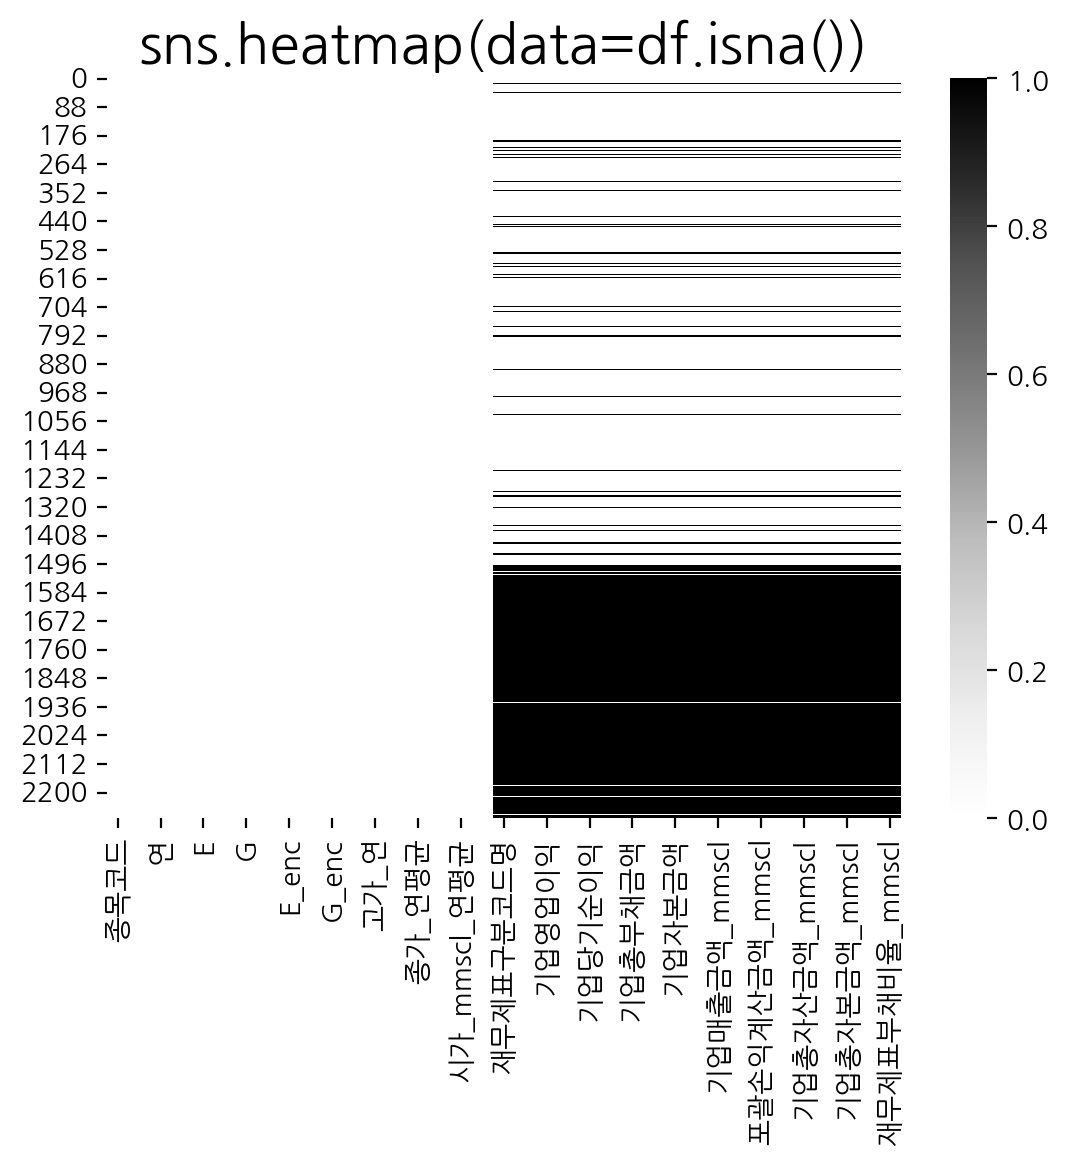



┌▣ df.isna().mean() ---- ---- ---- ----


,0
종목코드,0.000000
종목명,0.000000
연,0.000000
ESG종합,0.000000
E,0.000000
S,0.000000
G,0.000000
ESG종합_enc,0.000000
E_enc,0.000000
S_enc,0.000000


In [12]:
m.Summary_df(df)

### pair

In [ ]:
[
    "종목코드",
    "종목명",
    "연",
    "ESG종합",
    "E",
    "S",
    "G",
    "ESG종합_enc",
    "E_enc",
    "S_enc",
    "G_enc",
    "시가_연평균",
    "고가_연",
    "저가_연",
    "종가_연평균",
    "거래량",
    "시가_mmscl_연평균",
    "종가_mmscl_연평균",
    "재무제표구분코드명",
    "기업매출금액",
    "기업영업이익",
    "포괄손익계산금액",
    "기업당기순이익",
    "기업총자산금액",
    "기업총부채금액",
    "기업총자본금액",
    "기업자본금액",
    "재무제표부채비율",
    "기업매출금액_mmscl",
    "기업영업이익_mmscl",
    "포괄손익계산금액_mmscl",
    "기업당기순이익_mmscl",
    "기업총자산금액_mmscl",
    "기업총부채금액_mmscl",
    "기업총자본금액_mmscl",
    "기업자본금액_mmscl",
    "재무제표부채비율_mmscl",
]

In [17]:
l_ser = ["연"]
l_esg = ["ESG종합","E","S","G",]
l_esg_enc = ["ESG종합","E","S","G",]

sns.pairplot(df[["ESG종합","E","S","G"]])

ValueError: No variables found for grid columns.

## 연도, 등급별 count

In [13]:
list_esg = ['ESG종합', 'E', 'S', 'G']

for i in list_esg:
    display(df.pivot_table("종목코드", ["연"], [i], aggfunc='count').fillna(0))

ESG종합,S,A+,A,B+,B,C,D,N
연,,,,,,,,
2011,0,7,28,27,101,0,0,19
2012,0,4,24,42,128,0,0,1
2013,0,5,18,54,122,0,0,0
2014,0,2,27,48,121,0,0,0
2015,0,1,31,81,247,0,0,0
2016,0,8,33,96,238,0,0,0
2017,0,7,39,94,240,0,0,0
2018,0,12,47,98,221,0,0,7


E,S,A+,A,B+,B,C,D,N
연,,,,,,,,
2011,0,6,19,48,84,25,0,0
2012,0,6,14,59,100,20,0,0
2013,0,4,16,56,86,34,3,0
2014,0,7,18,57,81,34,1,0
2015,0,4,31,73,131,112,9,0
2016,0,19,19,70,158,92,17,0
2017,1,4,34,110,156,59,16,0
2018,0,9,27,123,149,65,12,0


S,S,A+,A,B+,B,C,D,N
연,,,,,,,,
2011,0,7,28,23,105,0,0,19
2012,0,10,28,37,124,0,0,0
2013,0,8,28,43,120,0,0,0
2014,0,3,37,36,122,0,0,0
2015,0,7,37,87,229,0,0,0
2016,0,32,25,119,199,0,0,0
2017,0,35,46,90,209,0,0,0
2018,0,48,47,115,168,0,0,7


G,S,A+,A,B+,B,C,D,N
연,,,,,,,,
2011,0,7,20,24,70,0,0,61
2012,0,8,18,60,112,0,0,1
2013,0,5,21,64,109,0,0,0
2014,0,6,27,57,108,0,0,0
2015,0,7,54,108,191,0,0,0
2016,0,3,72,94,206,0,0,0
2017,0,3,65,108,204,0,0,0
2018,0,7,59,111,201,0,0,7


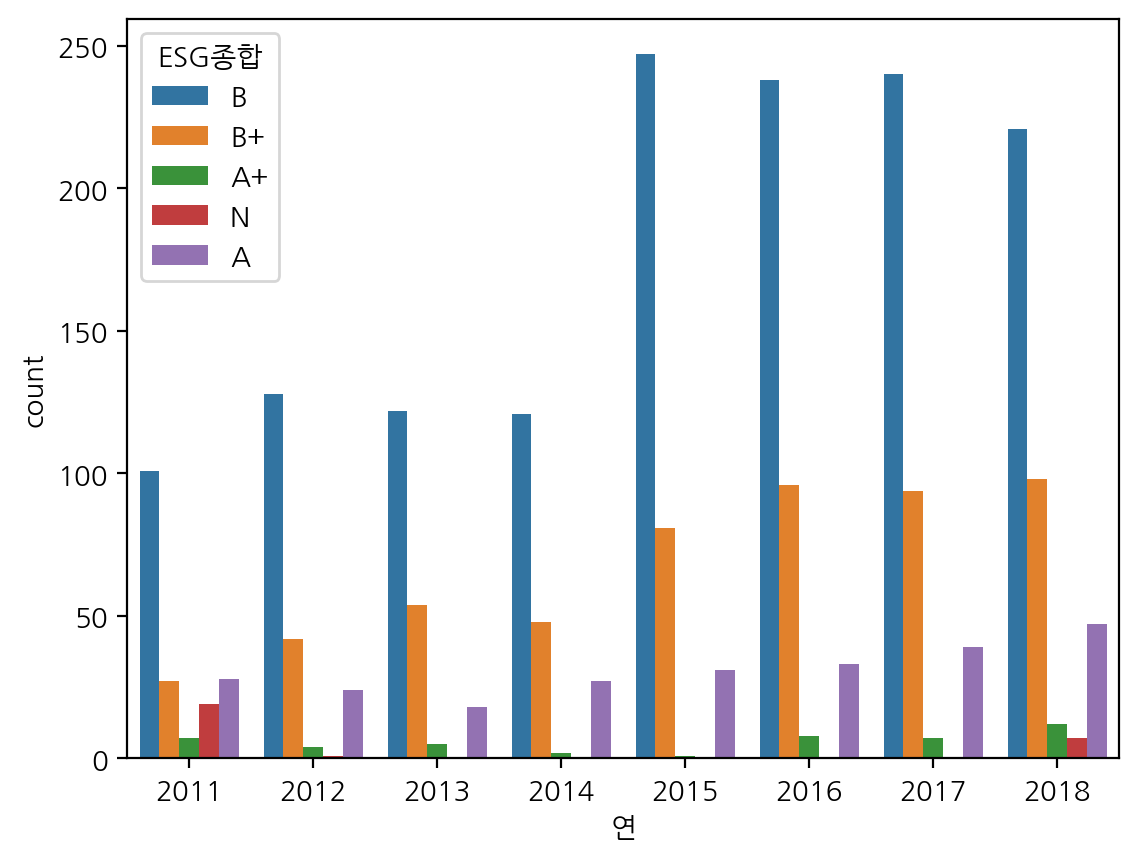

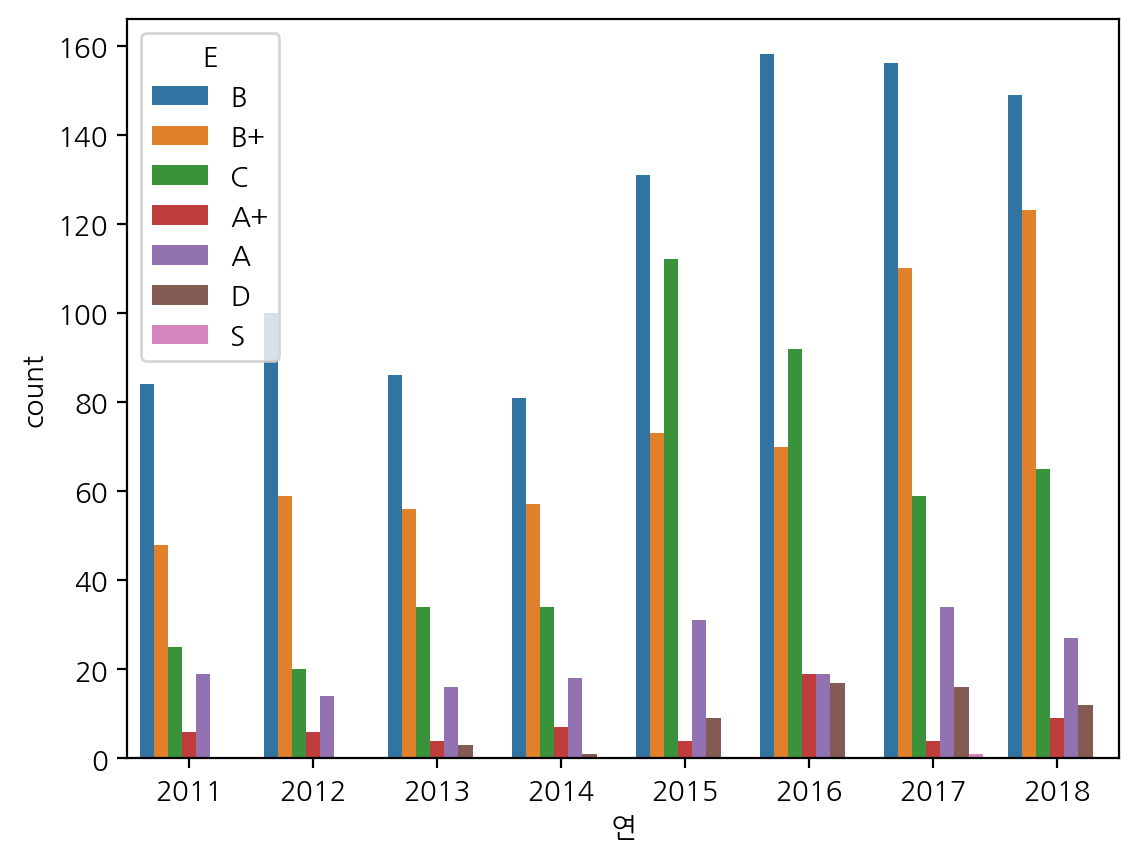

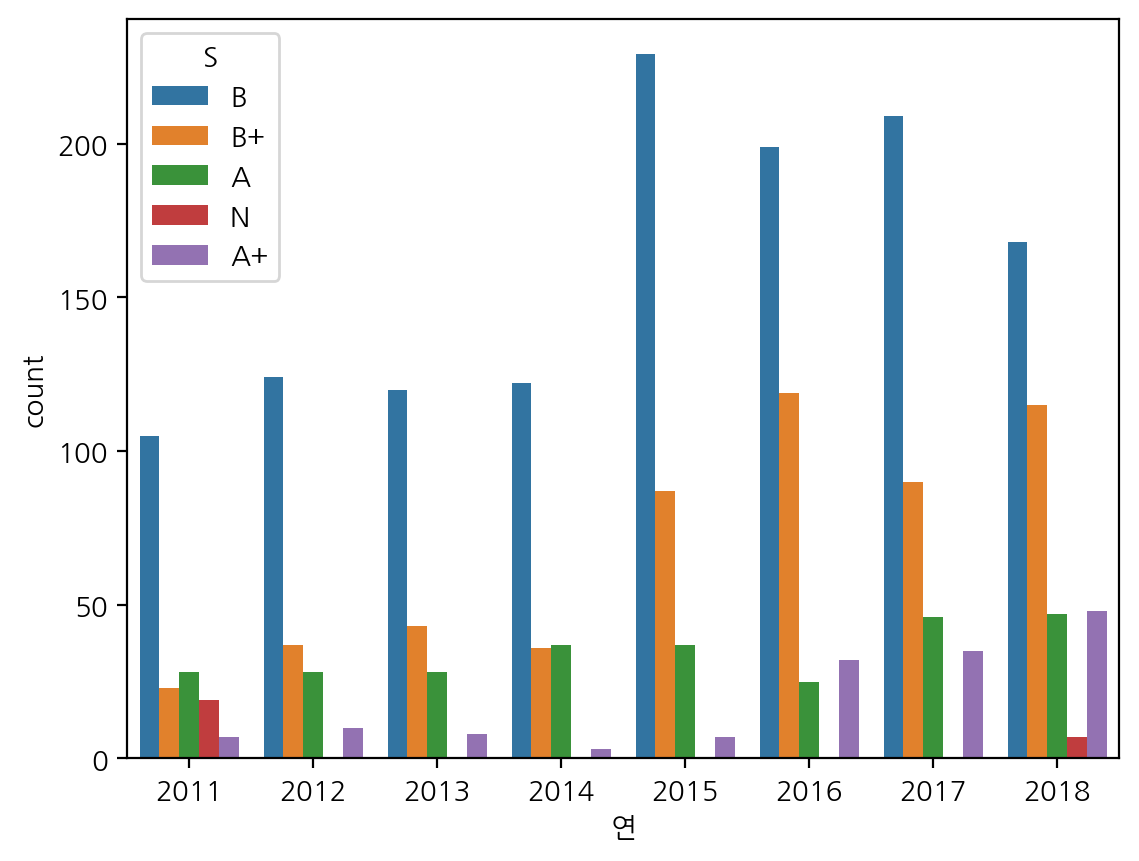

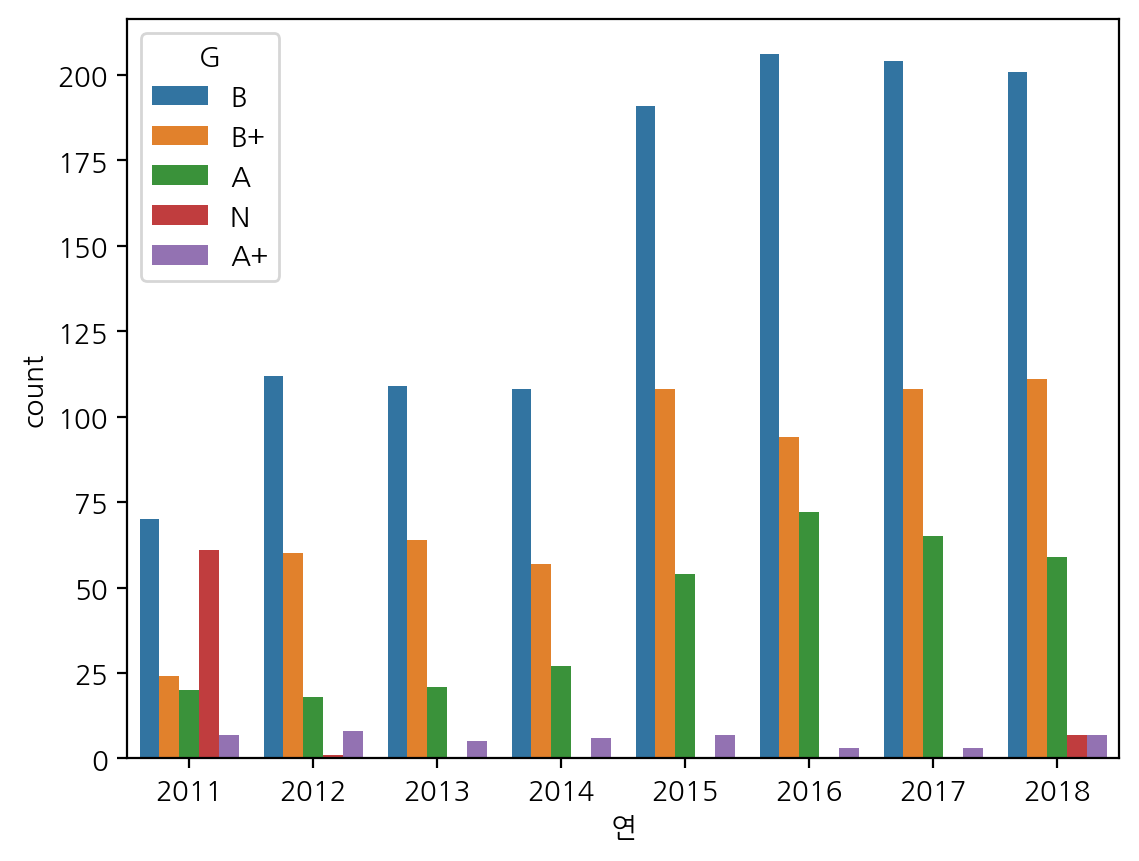

In [21]:
for i in list_esg:
    sns.countplot(df, x="연", hue=i)
    plt.show()

## 연도, 등급별 종가